# DÉTECTER LES FAUX BILLETS

Votre société de consulting informatique vous propose une nouvelle mission au ministère de l'Intérieur, dans le cadre de la lutte contre la criminalité organisée, à l'Office central pour la répression du faux monnayage. Votre mission si vous l'acceptez : **créer un algorithme de détection de faux billets**.  
Vous vous voyez déjà en grand justicier combattant sans relâche la criminalité organisée en pianotant à mains de maître votre ordinateur, pour façonner ce fabuleux algorithme  qui traquera la moindre fraude et permettra de mettre à jour les réseaux secrets de faux-monnayeurs ! La classe, non ?  
Bon, si on retombait les pieds sur terre ? Travailler pour la police judiciaire, c'est bien, mais vous allez devoir faire appel à vos connaissances en statistiques, alors on y va !

In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.mlab as mlab
import seaborn as sns
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing
from sklearn.metrics import accuracy_score

## I. Chargement des données

In [2]:
data = pd.read_csv('/Users/anissa/P6/notes.csv')
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


La _longueur du billet_ (en mm) : **length**  
La _hauteur du billet_ (mesurée sur le côté gauche, en mm) : **height_left**  
La _hauteur du billet_ (mesurée sur le côté droit, en mm) : **height_right**  
La _marge entre le bord supérieur_ du billet et l'image de celui-ci (en mm) : **margin_up**  
La _marge entre le bord inférieur_ du billet et l'image de celui-ci (en mm) : **margin_low**  
La _diagonale du billet_ (en mm) : **diagonal**  

In [3]:
data.shape

(170, 7)

Le df est composé de **170 billets** et de **7 variables** : 
* 6 variables quantititaves : _diagonal, height_left, height_right, margin_low, margin_up et length_
* 1 qualitative : *is_genuine*

In [4]:
# Recherche des valeurs manquantes
print('Valeurs manquantes :\n' + str(data.isnull().sum()))

Valeurs manquantes :
is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


In [5]:
# Recherche des valeurs dupliquées
print('Valeurs dupliquées : ', data.duplicated().sum())

Valeurs dupliquées :  0


## II. Analyses univariées et bivariées

In [6]:
description = data.groupby('is_genuine').describe().T
print(description)

is_genuine               False        True
diagonal     count   70.000000  100.000000
             mean   171.889857  171.976100
             std      0.297426    0.307981
             min    171.380000  171.040000
             25%    171.682500  171.790000
             50%    171.875000  172.005000
             75%    172.047500  172.162500
             max    173.010000  172.750000
height_left  count   70.000000  100.000000
             mean   104.230429  103.951500
             std      0.213130    0.296251
             min    103.780000  103.230000
             25%    104.082500  103.740000
             50%    104.215000  103.915000
             75%    104.377500  104.145000
             max    104.720000  104.860000
height_right count   70.000000  100.000000
             mean   104.145571  103.775900
             std      0.253152    0.292406
             min    103.440000  103.140000
             25%    103.982500  103.557500
             50%    104.170000  103.760000
           

Notre échantillon contient 170 billets : 100 vrais billets et 70 faux.

<AxesSubplot:>

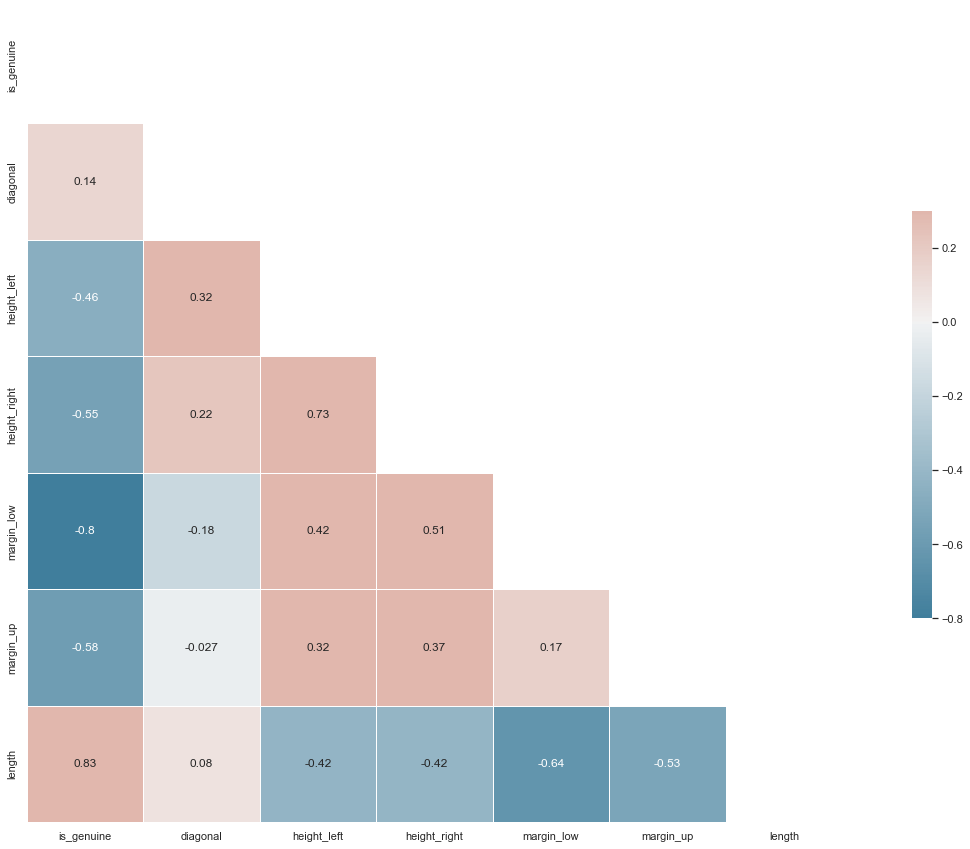

In [7]:
sns.set_theme(style="white")
# Generate a large random dataset
d = data

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Les variables "length" et "margin_low" sont les variables **les plus corrélées à la variable "is_genuine"**. Ce qui signifie que ce sont ces 2 variables qui sont les plus **importantes** lors de la détection de faux billets.  
On constate une **très faible corrélation** entre "margin_up" et "diagonal".  
Une **forte corrélation positive** est constatée entre "height_right" et "height_left" : les deux variables varient dans le même sens.   
Une **corrélation négative** existe entre "margin_low" et "length" : lorsqu'une des variables augmente, l'autre diminue.

On constate bien une différence significative entre les données des vrais et des faux billets.  
La variable "length" montre que la taille des faux billets est inférieure à celle des vrais.

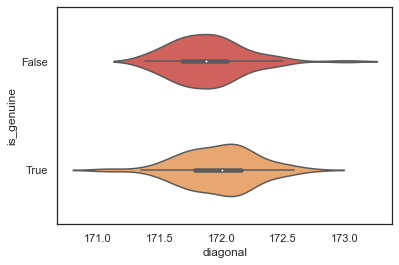

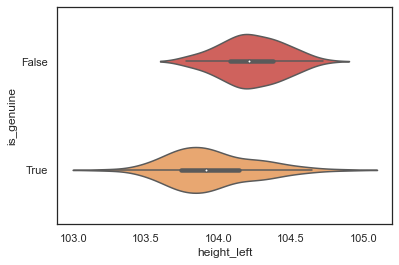

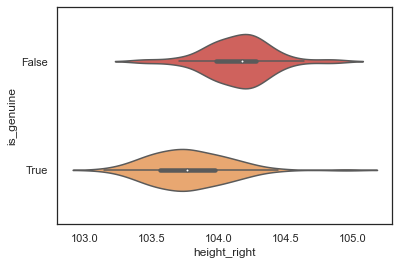

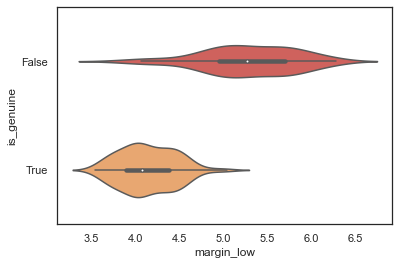

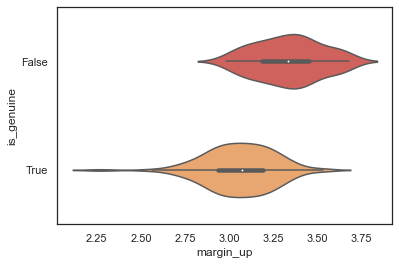

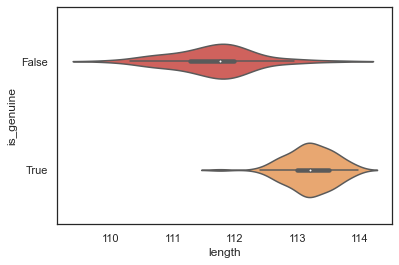

In [8]:
# Comparaison entre les vrais et faux billets (violinplot)
sns.set_palette('Spectral')
medianprops = dict(linewidth=2, color='grey')
meanprops={"marker":"o",
                       "markerfacecolor":"yellow", 
                       "markeredgecolor":"yellow",
                      "markersize":"5"}

for variable in data.columns[1:7]:
    sns_plot=sns.violinplot(
        x = data[variable], 
        y = data.is_genuine,
        orient = "h",
        medianprops = medianprops, showmeans=True, meanprops=meanprops,
        width = .5)
    plt.show()

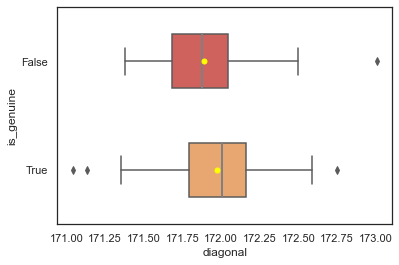

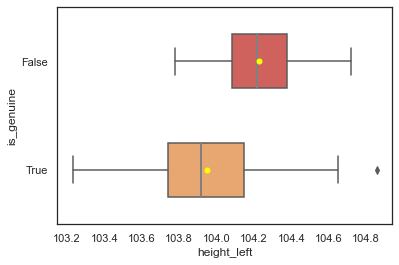

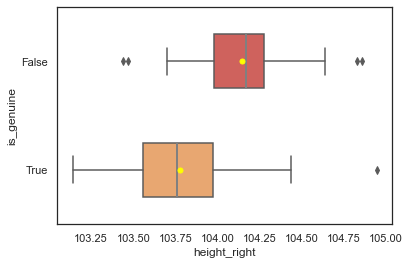

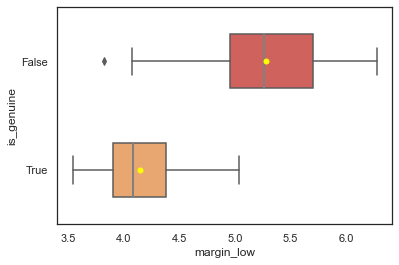

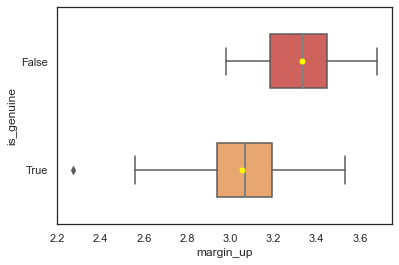

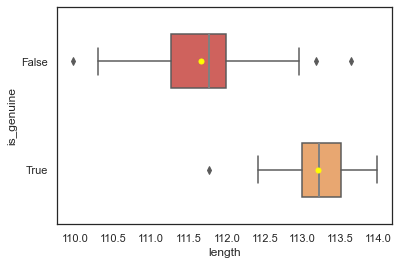

In [9]:
# Comparaison entre les dimensions des vrais et faux billets (boxplot)
medianprops = dict(linewidth=2, color='grey')
meanprops={"marker":"o",
                       "markerfacecolor":"yellow", 
                       "markeredgecolor":"yellow",
                      "markersize":"5"}

for variable in data.columns[1:7]:
    sns_plot=sns.boxplot(
        x = data[variable], 
        y = data.is_genuine,
        orient = "h",
        medianprops = medianprops, showmeans=True, meanprops=meanprops,
        width = .5)
    plt.show()

On constate ici, comme pour la matrice de corrélation, que les valeurs les plus discriminantes sont **"length"** et **"margin_low"** : différences importantes entre les dimensions et données plus hétérogènes.

## III. Analyse en Composantes Principales

_Source :_ http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_ACP_Python.pdf

In [10]:
# Paramétrage de l'environnement

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [11]:
data_acp = data.drop(columns='is_genuine') # on supprime la variable qualitative pour l'ACP

print(data_acp.shape) # dimension de la matrice
n = data_acp.shape[0] # nombre d'observations
p = data_acp.shape[1] # nombre de variables

(170, 6)


In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
Z = sc.fit_transform(data_acp)

print(Z)

[[-0.42834385  2.6694537   3.09656321 -0.13159013 -1.18987367  0.28163308]
 [-0.88755932 -1.09769709 -0.69125444 -0.86012554 -1.27473985  0.78069736]
 [-0.36274164 -1.03042654 -0.50943919 -0.30301023 -1.23230676  1.37740465]
 ...
 [ 1.73652911  0.68497248  0.52084721  0.38267015  0.67718214 -2.05094997]
 [-0.39554274 -0.32408577 -0.1458087   0.16839504  1.61071005 -0.75989238]
 [ 0.06367273 -0.22317994  0.06630909  1.45404575  0.38015054 -1.74717171]]


In [13]:
from sklearn.decomposition import PCA

acp = PCA() # instanciation
print(acp)

PCA()


In [14]:
coord = acp.fit_transform(Z)
print(acp.n_components_) # nombre de composantes calculées

6


In [15]:
# Variance expliquée
print(acp.explained_variance_)

[2.86372065 1.32522178 0.85912514 0.51460481 0.27840703 0.19442354]


In [16]:
# Valeur corrigée
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

[2.84687523 1.31742636 0.85407146 0.51157773 0.27676935 0.19327987]


In [17]:
# Proportion de valeurs expliquées
ratio = acp.explained_variance_ratio_ * 100
print(acp.explained_variance_ratio_)

[0.47447921 0.21957106 0.14234524 0.08526295 0.04612822 0.03221331]


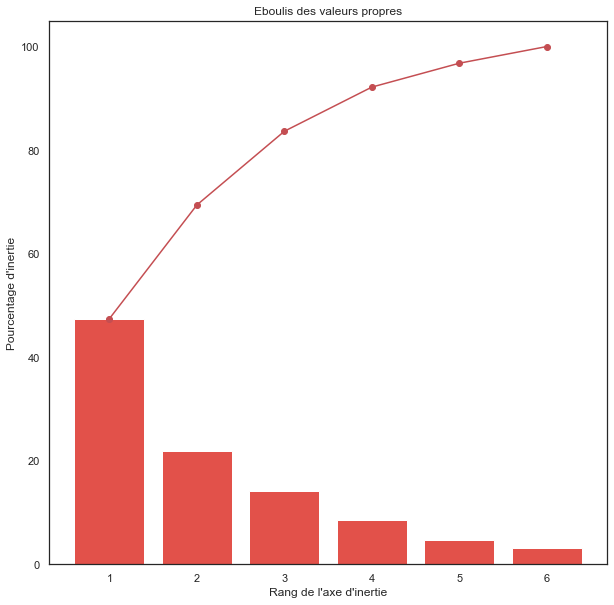

In [18]:
# Eboulis des valeurs propres
fig, ax = plt.subplots(figsize=(10,10))
scree = acp.explained_variance_ratio_*100

plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o', color='r')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")

plt.title("Eboulis des valeurs propres")

plt.savefig('/Users/anissa/P5_01_eboulis.jpg', dpi=1200)
plt.show(block=False)

Le critère du Kaiser nous conduit à retenir les deux premiers axes. En effet le premier axe retient 47.4% de l’inertie totale quant à l’axe 2 retient tout de même 22% de l’inertie, ce qui n’est pas négligeable. Et qui conduit à un taux d’inertie expliquée de 69,4%, ce qui est un très bon résultat.

In [19]:
# Contribution des individus dans l'inertie totale
di = np.sum(Z**2,axis=1)
print(pd.DataFrame({'ID':data_acp.index,'d_i':di}))

      ID        d_i
0      0  18.410598
1      1   5.444799
2      2   4.960527
3      3   4.805719
4      4  18.039567
..   ...        ...
165  165   7.673233
166  166  20.625650
167  167   8.567410
168  168   3.482926
169  169   5.369633

[170 rows x 2 columns]


In [20]:
# Qualité de représentation des individus - COS2
cos2 = coord**2

for j in range(p):
  cos2[:,j] = cos2[:,j]/di

qualite = pd.DataFrame({'id':data_acp.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1]})

print(qualite)

      id   COS2_F1   COS2_F2
0      0  0.251929  0.139000
1      1  0.818002  0.050822
2      2  0.784862  0.000466
3      3  0.882856  0.001652
4      4  0.320145  0.009417
..   ...       ...       ...
165  165  0.800651  0.004703
166  166  0.324059  0.411824
167  167  0.498809  0.083461
168  168  0.156908  0.271800
169  169  0.421817  0.217111

[170 rows x 3 columns]


In [21]:
print(qualite.sort_values('COS2_F1', ascending=False).head(10))

      id   COS2_F1   COS2_F2
143  143  0.973456  0.007584
46    46  0.962296  0.003343
101  101  0.908310  0.037607
94    94  0.906118  0.045729
123  123  0.904783  0.047258
90    90  0.898122  0.061454
111  111  0.896997  0.028916
132  132  0.885530  0.012440
3      3  0.882856  0.001652
105  105  0.882824  0.007530


In [22]:
print(qualite.sort_values('COS2_F2', ascending=False).head(10))

      id   COS2_F1   COS2_F2
21    21  0.000164  0.935643
156  156  0.013014  0.919036
33    33  0.017244  0.911419
34    34  0.004225  0.890595
23    23  0.006820  0.850794
36    36  0.110271  0.833974
53    53  0.013805  0.775037
5      5  0.132447  0.771985
26    26  0.089474  0.722621
22    22  0.026330  0.692767


In [23]:
#vérifions la théorie - somme en ligne des cos2 = 1
print(np.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [24]:
# Contribution aux axes
ctr = coord**2
for j in range(p):
  ctr[:,j] = ctr[:,j]/(n*eigval[j]) # eigval = c. 40 (variance expliquée et corrigé)

contribution = pd.DataFrame({'id':data_acp.index,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1]})
print(contribution)

      id    CTR_F1    CTR_F2
0      0  0.009584  0.011426
1      1  0.009203  0.001236
2      2  0.008045  0.000010
3      3  0.008767  0.000035
4      4  0.011933  0.000759
..   ...       ...       ...
165  165  0.012694  0.000161
166  166  0.013811  0.037927
167  167  0.008830  0.003193
168  168  0.001129  0.004227
169  169  0.004680  0.005205

[170 rows x 3 columns]


In [25]:
print(contribution.sort_values('CTR_F1', ascending=False).head(10))

      id    CTR_F1    CTR_F2
122  122  0.023758  0.012372
49    49  0.019620  0.007487
29    29  0.018089  0.000038
112  112  0.017950  0.016259
158  158  0.015836  0.002423
101  101  0.015483  0.001385
147  147  0.015085  0.001778
121  121  0.014871  0.000033
146  146  0.014783  0.000500
7      7  0.014226  0.004831


In [26]:
print(contribution.sort_values('CTR_F2', ascending=False).head(10))

      id    CTR_F1    CTR_F2
5      5  0.003155  0.039736
166  166  0.013811  0.037927
34    34  0.000073  0.033302
156  156  0.000211  0.032264
70    70  0.002197  0.031516
151  151  0.003251  0.026922
21    21  0.000002  0.025151
23    23  0.000088  0.023682
131  131  0.006470  0.019298
153  153  0.006999  0.019276


In [27]:
# Vérifions la théorie
print(np.sum(ctr,axis=0))

[1. 1. 1. 1. 1. 1.]


In [28]:
# Le champs components_ de l'objet ACP
print(acp.components_)

[[ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]
 [ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]
 [-0.08889419  0.12276016  0.15383022  0.5128076  -0.82114881  0.12691346]
 [-0.55973158  0.2780463   0.45893794 -0.22652773  0.13533955  0.57370304]
 [-0.22509444  0.71592059 -0.48699285 -0.31190784 -0.1939426  -0.25441684]
 [ 0.12216606  0.23213146 -0.4808135   0.54763041  0.35437971  0.52395111]]


In [29]:
# Racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

# Corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
  corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

# Afficher la matrice des corrélations variables x facteurs    
print(corvar)

[[ 0.1236346   0.89486346 -0.08215244 -0.40034612 -0.11841965  0.05370861]
 [ 0.80229967  0.38938864  0.11345001  0.19887167  0.37663775  0.10205336]
 [ 0.8298348   0.27035382  0.14216371  0.32825381 -0.25620145 -0.21138296]
 [ 0.72725782 -0.36790977  0.4739162  -0.16202319 -0.1640912   0.24075808]
 [ 0.59482939 -0.1619761  -0.75887278  0.09680115 -0.10203101  0.15579811]
 [-0.78520903  0.36102241  0.11728832  0.41033916 -0.13384583  0.23034781]]


In [30]:
# On affiche pour les deux premiers axes
print(pd.DataFrame({'id':data_acp.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

             id     COR_1     COR_2
0      diagonal  0.123635  0.894863
1   height_left  0.802300  0.389389
2  height_right  0.829835  0.270354
3    margin_low  0.727258 -0.367910
4     margin_up  0.594829 -0.161976
5        length -0.785209  0.361022


In [31]:
data_acp.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

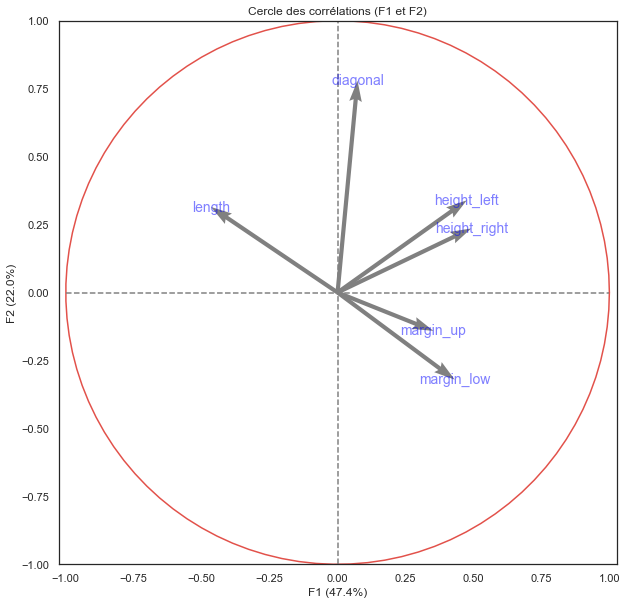

In [32]:
# Cercle des corrélations
pcs = acp.components_
features = data_acp.columns
display_circles(pcs, p, acp, [(0,1)], labels = np.array(features))

Sur F1, nous voyons les variables liées aux hauteurs et aux marges.  
La variable "length" est corrélée à F2.

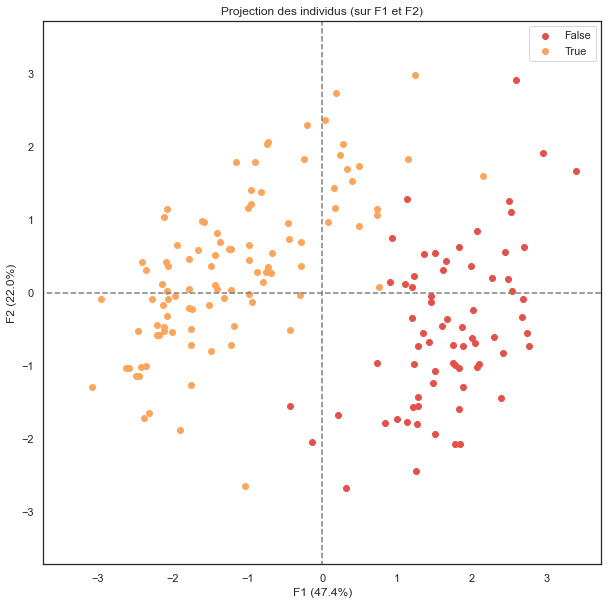

In [33]:
# Projection des individus

display_factorial_planes(coord, p, acp, [(0,1)], illustrative_var=data['is_genuine'])

Contient 69,4% de l’information : on observe très distinctement les deux groupes

In [34]:
# Cosinus carré des variables
cos2var = corvar**2
print(pd.DataFrame({'id':data_acp.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))

             id    COS2_1    COS2_2
0      diagonal  0.015286  0.800781
1   height_left  0.643685  0.151624
2  height_right  0.688626  0.073091
3    margin_low  0.528904  0.135358
4     margin_up  0.353822  0.026236
5        length  0.616553  0.130337


In [35]:
# Contributions
ctrvar = cos2var
for k in range(p):
  ctrvar[:,k] = ctrvar[:,k]/eigval[k]

# On n'affiche que pour les deux premiers axes
print(pd.DataFrame({'id':data_acp.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))

             id     CTR_1     CTR_2
0      diagonal  0.005369  0.607837
1   height_left  0.226102  0.115091
2  height_right  0.241888  0.055480
3    margin_low  0.185784  0.102744
4     margin_up  0.124284  0.019915
5        length  0.216572  0.098933


### IV. Classification : k-means

Nous allons séparer notre échantillon en 2 groupes : variances égales et intertie minime.

In [36]:
from sklearn.cluster import KMeans 
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import linear_model
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

X = data.values

km = KMeans(n_clusters=2)
km.fit(X)
clustersk = km.labels_

data_clusterk = pd.DataFrame({'clusters_kmeans' : clustersk})
data = data.join(data_clusterk)
illustrative_var = data['clusters_kmeans']

In [37]:
description = data.groupby('clusters_kmeans').describe().transpose()
print(description)

clusters_kmeans              0           1
diagonal     count   69.000000  101.000000
             mean   171.890725  171.974653
             std      0.299516    0.306782
             min    171.380000  171.040000
             25%    171.680000  171.790000
             50%    171.890000  172.000000
             75%    172.050000  172.160000
             max    173.010000  172.750000
height_left  count   69.000000  101.000000
             mean   104.228116  103.955842
             std      0.213805    0.297977
             min    103.780000  103.230000
             25%    104.070000  103.740000
             50%    104.210000  103.920000
             75%    104.370000  104.160000
             max    104.720000  104.860000
height_right count   69.000000  101.000000
             mean   104.145217  103.779802
             std      0.254989    0.293571
             min    103.440000  103.140000
             25%    103.980000  103.560000
             50%    104.170000  103.760000
           

In [38]:
description2 = data.groupby('is_genuine').describe().transpose()
print(description2)

is_genuine                  False        True
diagonal        count   70.000000  100.000000
                mean   171.889857  171.976100
                std      0.297426    0.307981
                min    171.380000  171.040000
                25%    171.682500  171.790000
                50%    171.875000  172.005000
                75%    172.047500  172.162500
                max    173.010000  172.750000
height_left     count   70.000000  100.000000
                mean   104.230429  103.951500
                std      0.213130    0.296251
                min    103.780000  103.230000
                25%    104.082500  103.740000
                50%    104.215000  103.915000
                75%    104.377500  104.145000
                max    104.720000  104.860000
height_right    count   70.000000  100.000000
                mean   104.145571  103.775900
                std      0.253152    0.292406
                min    103.440000  103.140000
                25%    103.982500 

In [39]:
# Moyennes des dimensions pour les 2 clusters
data.groupby('clusters_kmeans').mean().drop("is_genuine",axis=1)

,diagonal,height_left,height_right,margin_low,margin_up,length
clusters_kmeans,,,,,,
0,171.890725,104.228116,104.145217,5.278261,3.334638,111.632029
1,171.974653,103.955842,103.779802,4.157030,3.058218,113.211485


In [40]:
# Moyennes des dimensions pour les 2 clusters (k-means)
data.groupby('is_genuine').mean().drop("clusters_kmeans",axis=1)

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200


Cette comparaison permet de voir que le clustering a bien fonctionné : la fonction a crée deux groupes qui sont très proches des groupes vrais et faux. On réalise maintenant une matrice de confusion afin de vérifier la qualité de notre classification.

In [41]:
# Matrice de confusion
df_confusion = pd.crosstab(data.is_genuine,data.clusters_kmeans)
df_confusion

clusters_kmeans,0,1
is_genuine,,
False,69,1
True,0,100


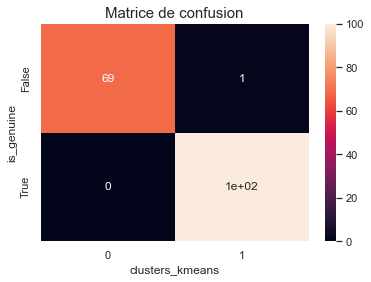

In [42]:
# Représentation graphique de la matrice de confusion : heat map
sns.heatmap(df_confusion, annot=True)

plt.title("Matrice de confusion", size=15)
plt.savefig('/Users/anissa/P5_01_matrice_confusion.jpg', dpi=1200)
plt.show()

69 vrais négatifs et 100 vrais positifs ainsi qu'1 faux négatif (négatif à tord).  
Pour comparaison, en regardant la variable "is_genuine" de notre échantillon, il y a 100 vrais billets et 70 faux billets.

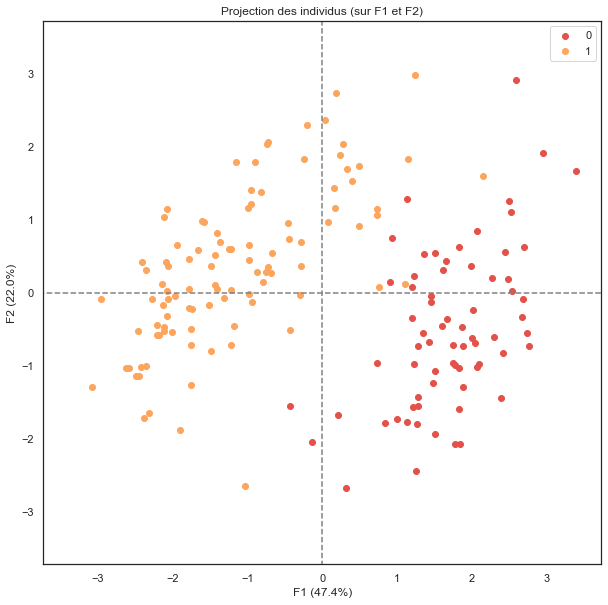

In [43]:
# Projection des individus
display_factorial_planes(coord, p, acp, [(0,1)],
                         illustrative_var=data.clusters_kmeans)

### V. Modélisation

_sources :_ 
* https://www.youtube.com/watch?v=xYDgnjtVFgU
* http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Python_Regression_Logistique.pdf
* https://towardsdatascience.com/evaluating-machine-learning-classification-problems-in-python-5-1-metrics-that-matter-792c6faddf5

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

In [45]:
# Variables explicatives
X = data[['length', 'height_left', 'height_right', 'margin_low', 'margin_up', 'diagonal']]

# Variable à expliquer
y = data.is_genuine

In [46]:
# Partition aléatoire du jeu de données en 80% pour créer le modèle, 20% pour tester le modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [47]:
# Régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [48]:
# Stockage de prédictions
predictions = model.predict(X_test)
print(predictions)
print(y_test)

[ True  True  True False False  True False False False False  True  True
 False False False False  True  True  True  True  True  True  True  True
 False  True  True False  True False  True  True False False]
28      True
85      True
42      True
114    False
163    False
20      True
124    False
112    False
133    False
119    False
0       True
21      True
155    False
148    False
160    False
108    False
90      True
43      True
14      True
89      True
86      True
87      True
65      True
27      True
137    False
32      True
46      True
128    False
59      True
165    False
52      True
81      True
100    False
150    False
Name: is_genuine, dtype: bool


In [49]:
# Evaluation du modèle
print(classification_report(y_test, predictions))
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        15
        True       1.00      1.00      1.00        19

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

1.0


In [50]:
# Matrice de confusion
cm = confusion_matrix(y_test, predictions)

# Assignation du nom des colonnes
cm_df = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,15,0
Actual Positive,0,19


## VI. Calculs manuels des indicateurs

In [51]:
# Vrai positif (true positive)
TP = cm_df.iloc[1,1]

# Vrai négatif (true negative)
TN = cm_df.iloc[0,0]

# Faux négatif (false negative)
FN = cm_df.iloc[0,1]

# Faux positif (false positive)
FP = cm_df.iloc[1,0]

In [52]:
# Calcul de la sensibilité (taux de vrais positifs)
conf_sensitivity = (TP / float(TP + FN))

# Calcul de la spécificité (taux de vrais négatifs)
conf_specificity = (TN / float(TN + FP))

print("sensivity =",conf_sensitivity)
print("specificity =",conf_specificity)

sensivity = 1.0
specificity = 1.0


In [53]:
# Calcul de la précision (accuracy score)
conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
conf_accuracy

1.0

In [54]:
# Moyenne entre la sensibilité et la spécificité (balanced accuracy)
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, predictions, sample_weight=None, adjusted=False)

1.0

### VII. Test nouvel échantillon

In [55]:
new_sample = pd.read_csv('/Users/anissa/P6/example.csv')
new_sample.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [56]:
# Préparation des données
new_predict = new_sample[['length', 'height_left', 'height_right', 'margin_low', 'margin_up', 'diagonal']]

# Application du modèle
predict = model.predict(new_predict)

# Probabilités
model.predict_proba(new_predict)

array([[0.94701983, 0.05298017],
       [0.98784444, 0.01215556],
       [0.9660883 , 0.0339117 ],
       [0.14979544, 0.85020456],
       [0.00541888, 0.99458112]])

In [57]:
# Ordre de lecture des probabilités
model.classes_

array([False,  True])

In [58]:
# Calcul des probas d'affectaion sur l'ech. à prédire
probas_ex = model.predict_proba(new_predict)

new_predict['Probas_faux'] = probas_ex[:,0]
new_predict['Probas_vrais'] = probas_ex[:,1]
new_predict

,length,height_left,height_right,margin_low,margin_up,diagonal,Probas_faux,Probas_vrais
0,111.42,104.01,103.54,5.21,3.30,171.76,0.947020,0.052980
1,112.09,104.17,104.13,6.00,3.31,171.87,0.987844,0.012156
2,111.57,104.58,104.29,4.99,3.39,172.00,0.966088,0.033912
3,113.20,104.55,104.34,4.44,3.03,172.49,0.149795,0.850205
4,113.33,103.63,103.56,3.77,3.16,171.65,0.005419,0.994581


In [59]:
# Ajout du resultat et création du df
prediction=pd.DataFrame({'id': new_sample.id,
                        'probalité_true' : new_predict.Probas_vrais,
                        'probalité_false' : new_predict.Probas_faux,
                        'prédiction' : predict})

prediction

,id,probalité_true,probalité_false,prédiction
0,A_1,0.052980,0.947020,False
1,A_2,0.012156,0.987844,False
2,A_3,0.033912,0.966088,False
3,A_4,0.850205,0.149795,True
4,A_5,0.994581,0.005419,True


Notre échantillon contient donc 3 faux billets et 2 vrais.